### Importing libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from pathlib import Path
import pandas as pd
from tqdm import tqdm

#### Reading Directories

In [18]:
train_path = Path().resolve()/'data_preprocessing_04target/Training_Set/'
val_path = Path().resolve()/'data_preprocessing_04target/Validation_Set'
test_path = Path().resolve()/'data_preprocessing_04target/Test_Set'

#### Functions


In [19]:
def histogram_match(moving, fixed):
    """ Matches histogram of moving image to fixed image """
    matcher = sitk.HistogramMatchingImageFilter()
    if fixed.GetPixelID() in (sitk.sitkUInt8, sitk.sitkInt8):
        matcher.SetNumberOfHistogramLevels(128)
    else:
        matcher.SetNumberOfHistogramLevels(1024)
    matcher.SetNumberOfMatchPoints(7)
    matcher.ThresholdAtMeanIntensityOn()
    return matcher.Execute(moving, fixed)


def bias_field_correction(test_img, shrinkFactor=1):
    """Performs bias field correction on image"""
    inputImage = sitk.Cast(test_img, sitk.sitkFloat32)
    image = inputImage

    if shrinkFactor > 1:
        image = sitk.Shrink(
            inputImage, [shrinkFactor] * inputImage.GetDimension()
        )

    corrector = sitk.N4BiasFieldCorrectionImageFilter()        

    return corrector.Execute(image)

def resample2target(moving, target):
    """Resamples moving image to target image"""

    return sitk.Resample(moving, target.GetSize(),
                                    sitk.Transform(), 
                                    sitk.sitkLinear,
                                    target.GetOrigin(),
                                    target.GetSpacing(),
                                    target.GetDirection(),
                                    0,
                                    target.GetPixelID())

# Denoising filter
def denoise(inputImage):
    inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
    return sitk.DiscreteGaussian(inputImage)

def preprocess_image(moving, target):
    """Preprocesses moving image to match target image
    is origin, resolution, spacing, histogram and performs bias field correction"""
    moving = bias_field_correction(moving)
    moving = resample2target(moving, target)
    moving = histogram_match(moving, target)
    return moving

Select Target image: IBSR_04

In [20]:
target_histogram = sitk.ReadImage(str(train_path/'IBSR_04/IBSR_04.nii.gz'))
target_histogram_bias=bias_field_correction(target_histogram)


Preprocessing step overwriting the original image

##### Validation set

In [23]:
for val_set in val_path.iterdir():
    val_img = sitk.ReadImage(str(val_set/f'{val_set.name}.nii.gz'))
    val_img = bias_field_correction(val_img)
    val_img = histogram_match(val_img, target_histogram)  
    #val_img=preprocess_image(val_img,target_histogram_bias)   
    # create results folder, in this case we will overwrite the image
    results_path = val_set
    results_path.mkdir(exist_ok=True)
    sitk.WriteImage(val_img, str(results_path/f'{val_set.name}.nii.gz'))

##### Training set

In [22]:
for train_set in train_path.iterdir():
    train_img = sitk.ReadImage(str(train_set/f'{train_set.name}.nii.gz'))
    train_img = bias_field_correction(train_img)
    train_img = histogram_match(train_img, target_histogram_bias) 
    # create results folder, in this case we will overwrite the image
    results_path = train_set
    results_path.mkdir(exist_ok=True)
    sitk.WriteImage(train_img, str(results_path/f'{train_set.name}.nii.gz'))
    

##### Testing set

In [25]:
for test_set in test_path.iterdir():
    test_img = sitk.ReadImage(str(test_set/f'{test_set.name}.nii.gz'))
    test_img = preprocess_image(test_img, target_histogram_bias) 
    # create results folder, in this case we will overwrite the image
    results_path = test_set
    results_path.mkdir(exist_ok=True)
    
    sitk.WriteImage(test_img, str(results_path/f'{test_set.name}.nii.gz'))

Plotting Histograms

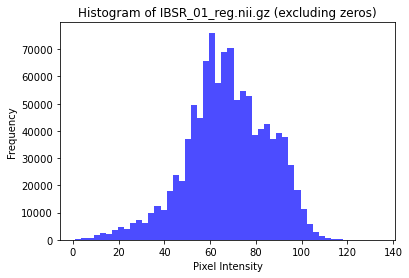

In [35]:
# Flatten the 3D array to a 1D array
inputImage_array = sitk.GetArrayFromImage(target_histogram_bias)
flat_array = inputImage_array.flatten()

# Exclude zero values from the histogram
non_zero_values = inputImage_array[inputImage_array != 0]

# Plot the histogram for the non-zero values
plt.hist(non_zero_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Target Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

Text(0, 0.5, 'Frequency')

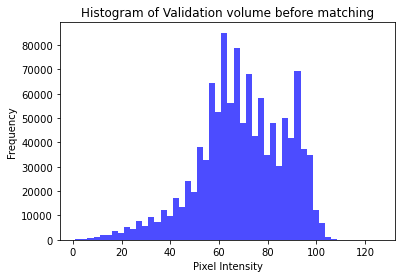

In [51]:
val_beforematching= sitk.ReadImage(str(r'C:\Users\carme\Desktop\GIRONA\MISA_PROJECT\IBSR18-tissue-segmentation\TrainingValidationTestSets\Validation_Set\IBSR_14\IBSR_14.nii.gz'))
# Flatten the 3D array to a 1D array
inputImage_array = sitk.GetArrayFromImage(val_beforematching)
flat_array = inputImage_array.flatten()

# Exclude zero values from the histogram
non_zero_values = inputImage_array[inputImage_array != 0]

# Plot the histogram for the non-zero values
plt.hist(non_zero_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Validation volume before matching')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

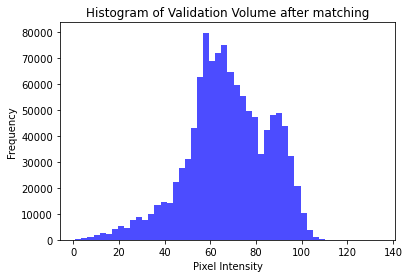

In [50]:
val_aftermatching= sitk.ReadImage(str(val_path/'IBSR_14/IBSR_14.nii.gz'))
# Flatten the 3D array to a 1D array
inputImage_array = sitk.GetArrayFromImage(val_aftermatching)
flat_array = inputImage_array.flatten()

# Exclude zero values from the histogram
non_zero_values = inputImage_array[inputImage_array != 0]

# Plot the histogram for the non-zero values
plt.hist(non_zero_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Validation Volume after matching')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

For preprocessing all validation with each training volume as target

Generating folder per validation per target

In [6]:
""" for train_set in train_path.iterdir():
    train_img = sitk.ReadImage(str(train_set/f'{train_set.name}.nii.gz'))
    train_img = bias_field_correction(train_img)
    
    
    # create results folder
    results_path = val_set/'results_preprocessed'
    results_path.mkdir(exist_ok=True)
    
    sitk.WriteImage(val_img, str(results_path/f'{val_set.name}_bias_corrected.nii.gz'))
    

    for train_set in train_path.iterdir():
                
        # load image and preprocess and load the label
        train_img = sitk.ReadImage(str(train_set/f'{train_set.name}.nii.gz'))
        train_img = preprocess_image(moving=train_img, target=val_img)
        
        train_label = sitk.ReadImage(str(train_set/f'{train_set.name}_seg.nii.gz'))
        train_label = resample2target(train_label, val_img)
        
                
        # create results folder per train case
        results_path_train = results_path/train_set.name
        results_path_train.mkdir(exist_ok=True)
        
        # save registered image and label
        sitk.WriteImage(train_img, str(results_path_train/f'{train_set.name}_reg.nii.gz'))
        sitk.WriteImage(train_label,  str(results_path_train/f'{train_set.name}_seg_reg.nii.gz'))
        
      
        val_img = sitk.Cast(val_img, sitk.sitkFloat32)
 """

Example of preprocessed image and denoised image

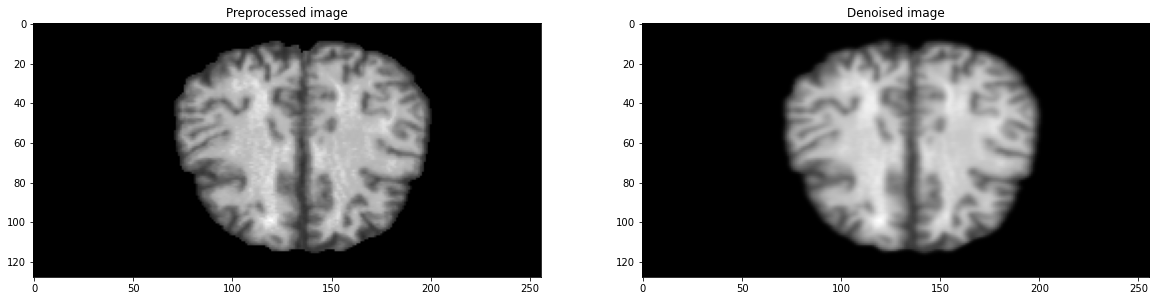

In [11]:
inputImage = sitk.ReadImage(str(val_path /'IBSR_11' / 'results_preprocessed'/'IBSR_01' / 'IBSR_01_reg.nii.gz'), sitk.sitkFloat32)
inputImage_array = sitk.GetArrayFromImage(inputImage)
inputImage_array.shape

# show denoised image and original image
denoised_array = sitk.GetArrayFromImage(denoise(inputImage))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
# add title
plt.title('Preprocessed image')
plt.imshow(inputImage_array[150,:,:], cmap='gray')
plt.subplot(1,2,2)
plt.title('Denoised image')
plt.imshow(denoised_array[150,:,:], cmap='gray')

In [ ]:
#Other normalization methods. 
##https://intensity-normalization.readthedocs.io/en/latest/algorithm.html